<p align="right">
    <img src="Zewail-City.png">
</p>


---

# __Chameleon model in Modified Gravity vs Mass Models__


## Lagrangian and the Equation of Motion

In Chameleon gravity, a real scalar field $ \phi $ is conformally coupled to matter fields $ \psi^{(i)} $. The full action is given by:

$$
\mathcal{L} = \sqrt{-g} \left\{ -\frac{M_{\text{Pl}}^2}{2} R + \frac{1}{2} (\partial \phi)^2 + V(\phi) \right\} + \mathcal{L}_m\left(\psi^{(i)}, \, e^{-2\beta_i \phi / M_{\text{Pl}}} g_{\mu\nu} \right)
$$

Where:
- $ \mathcal{L} $ : Total Lagrangian density  
- $ M_{\text{Pl}} $ : Reduced Planck mass = $ \frac{1}{\sqrt{8\pi G}} $  
- $ R $ : Ricci scalar  
- $ \phi $ : Chameleon scalar field  
- $ V(\phi) $ : Scalar field potential  
- $ \mathcal{L}_m $ : Matter Lagrangian  
- $ \psi^{(i)} $ : Matter fields  
- $ g_{\mu\nu} $ : Metric tensor in the Einstein frame  
- $ \beta_i $ : Coupling constants between the scalar field and matter fields  

The resulting equation of motion for a static scalar field is:

$$
\nabla^2 \phi = \frac{\partial}{\partial \phi} V_{\text{eff}}(\phi)
$$

With the effective potential defined as:

$$
V_{\text{eff}}(\phi) = V(\phi) + \rho e^{\beta \phi / M_{\text{Pl}}}
$$

Assuming small field values $ \beta \phi / M_{\text{Pl}} \ll 1 $, this simplifies to:

$$
\nabla^2 \phi = \frac{\beta}{M_{\text{Pl}}}\rho + V'(\phi)
$$

This equation governs how the Chameleon field behaves under different matter density distributions.

### A Note on the Scalar Field Potential

A typical form of the scalar field potential assumes a **power-law** shape:

$$
V(\phi) = \Lambda^{4+n} \phi^{-n}
$$

Where:
- $ \Lambda $ : Energy scale parameter (often related to dark energy)
- $ n $ : Positive exponent that defines the model's behavior

This choice of potential leads to a field-dependent effective mass that increases with local matter density, enabling the **screening mechanism** that characterizes Chameleon gravity.

---


## Mass Models
Six different mass density models are considered for galaxy clusters:

1. **NFW Profile**  
   $$
   \rho(r) = \frac{\rho_s}{(r/r_s)(1 + r/r_s)^2}
   $$

2. **bNFW Profile**  
   Generalized NFW with exponent $ b > 2 $:
   $$
   \rho(r) = \frac{\rho_s}{(r/r_s)^b (1 + r/r_s)^{3 - b}}
   $$

3. **Generalized NFW (gNFW)**  
   Allows variable inner slope $ \gamma $:
   $$
   \rho(r) = \frac{\rho_s}{(r/r_s)^\gamma (1 + r/r_s)^{3 - \gamma}}
   $$

4. **Burkert Profile**  
   Core-like central density:
   $$
   \rho(r) = \frac{\rho_s}{(1 + r/r_s)(1 + (r/r_s)^2)}
   $$

5. **Isothermal Sphere**  
   Constant core density, steeper outer decline:
   $$
   \rho(r) = \frac{\rho_s}{(1 + r/r_s)^2}
   $$

6. **Einasto Profile**  
   Smoothly varying profile with parameter $ m $ where $ m \in \mathbb{N} $ is a characteristic exponent:
   $$
   {\rho(r) = \rho_s \exp\left\{-2m \left[\left(\frac{r}{r_s}\right)^{\frac{1}{m}} - 1\right]\right\}}
   $$


Each model has two main parameters: central density $ \rho_s $ and scale radius $ r_s $.


In [81]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.special import hyp2f1, gammaincinv, gammaincc, gamma, erf
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import emcee
import getdist
from getdist import MCSamples, plots
import imageio 

In [5]:
# Constants
rho_s = 5e14  # Solar masses per Mpc^3
r_s = 0.5     # Mpc
beta = 0.5          # Coupling constant
phi_inf = 5e-5      # Asymptotic value of the scalar field
M_Pl = 1 / np.sqrt(8 * np.pi * 4.30091e-67)  # Reduced Planck mass in GeV^-1 (approx)

r = np.logspace(-2, 1, 500)  # Radial grid from 0.01 to 10 Mpc

In [6]:
# Define density profiles
def nfw(r):
    return rho_s / ((r / r_s) * (1 + r / r_s)**2)

def burkert(r):
    return rho_s / ((1 + r / r_s) * (1 + (r / r_s)**2))

def hernquist(r, b=3):
    return rho_s / ((r / r_s)**b * (1 + r / r_s)**(4 - b))

def gnfw(r, gamma=1.2):
    return rho_s / ((r / r_s)**gamma * (1 + r / r_s)**(3 - gamma))

def isothermal(r):
    return rho_s / (1 + (r / r_s)**2)**(3/2)

def einasto(r, m=2):
    return rho_s * np.exp(-2/m * ((r / r_s)**m - 1))

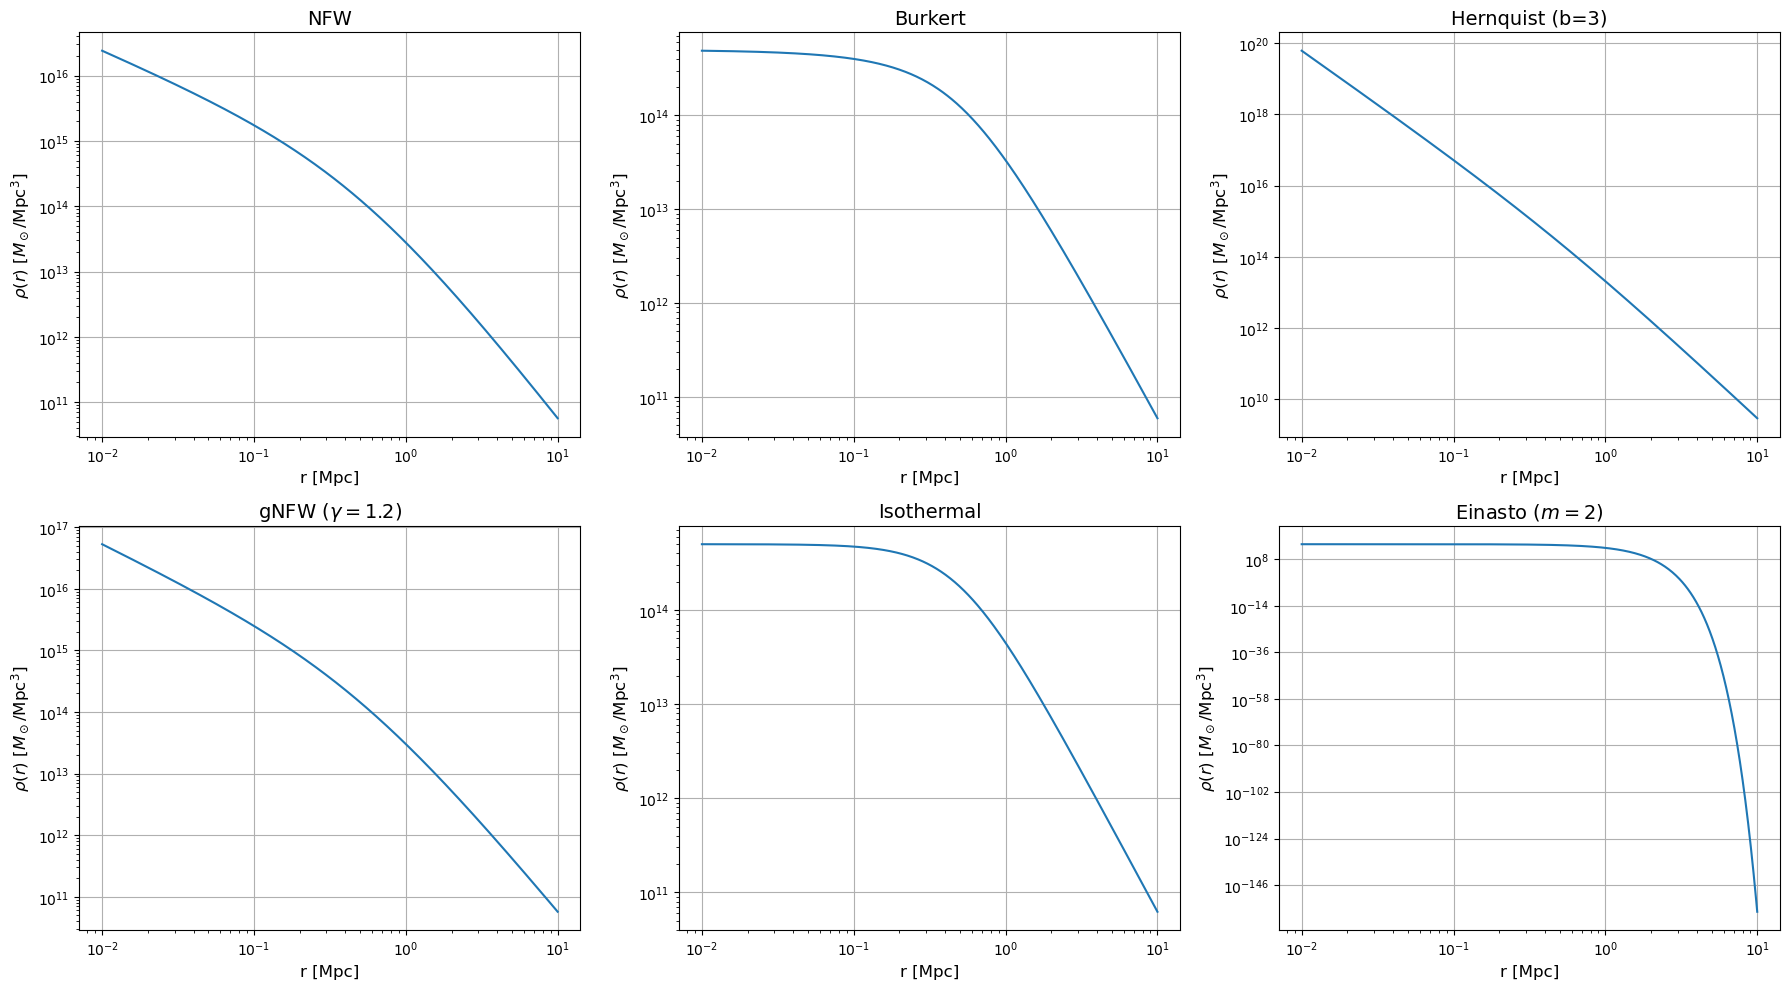

In [7]:
# Profile list
profiles = [
    ('NFW', nfw),
    ('Burkert', burkert),
    ('Hernquist (b=3)', lambda r: hernquist(r, b=3)),
    ('gNFW ($\\gamma=1.2$)', lambda r: gnfw(r, gamma=1.2)),
    ('Isothermal', isothermal),
    ('Einasto ($m=2$)', lambda r: einasto(r, m=2)),
]

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=False, sharey=False)
axes = axes.flatten()

for i, (name, profile_func) in enumerate(profiles):
    ax = axes[i]
    ax.loglog(r, profile_func(r))
    ax.set_title(name, fontsize=14)
    ax.set_xlabel('r [Mpc]', fontsize=12)
    ax.set_ylabel(r'$\rho(r)$ [$M_\odot/\text{Mpc}^3$]', fontsize=12)
    ax.grid(True)

plt.tight_layout()
plt.show()

## Field Solutions

The Chameleon field is solved separately in two regions:

- **Interior (screened region):** High density → negligible field gradient
  $$
  \nabla^2 \phi \approx 0 \Rightarrow \phi_{\text{int}}(r) \approx \left(\frac{\beta \rho(r)}{n \Lambda^{4+n} M_{Pl}}\right)^{-1/(n+1)}
  $$

- **Exterior (unscreened region):** Low density → fifth force becomes significant
  $$
  \nabla^2 \phi \approx \frac{\beta}{M_{Pl}} \rho
  $$

Using spherical symmetry and assuming $ \rho(r) = \rho_s f(x) $, where $ x = r/r_s $, the exterior solution becomes:

$$
x^2 \frac{d\phi_{\text{ext}}}{dx} = B \int f(x) x^2 dx + C_s
$$

Where:
- $ B = \frac{\beta \rho_s r_s^2}{M_{Pl}} $
- $ C_s $: Integration constant determined by boundary conditions at the screening radius $ r_c $

The field solutions are matched at $ r = r_c $, ensuring continuity and smooth transition between screened and unscreened regimes.

### Gravitational Potential in Chameleon Gravity

The total gravitational potential $ \Phi $ in Chameleon gravity includes contributions from both Newtonian gravity and the fifth force mediated by the scalar field $ \phi $. It is given by:

$$
\frac{d\Phi}{dr} = \frac{G M(r)}{r^2} + \frac{\beta}{M_{Pl}} \frac{d\phi}{dr}
$$

Or equivalently:

$$
\frac{d\Phi}{dr} = \frac{G}{r^2} \left[ M(r) + \frac{\beta}{G M_{Pl}} r^2 \frac{d\phi}{dr} \right]
$$

Where:
- $ M(r) $: Mass enclosed within radius $ r $.
- $ M_{\text{eff}}(r) = \frac{\beta}{G M_{Pl}} r^2 \frac{d\phi}{dr} $: Effective mass due to the fifth force.

This shows that the scalar field gradient contributes an additional effective mass term, modifying the gravitational potential.

### The Fifth Force

In Chameleon gravity, the scalar field mediates an additional **fifth force**, which affects the motion of non-relativistic matter. This force can be expressed as:

$$
F_{\phi} = -\frac{\beta}{M_{Pl}} \frac{d\phi}{dr}
$$

Compared to the standard Newtonian acceleration:

$$
a_{\text{Newton}} = \frac{G M(r)}{r^2}
$$

The total effective gravitational acceleration becomes:

$$
a_{\text{eff}} = a_{\text{Newton}} + F_{\phi} = \frac{G M(r)}{r^2} - \frac{\beta}{M_{Pl}} \frac{d\phi}{dr}
$$

Thus, the fifth force enhances or modifies the net gravitational pull depending on the local environment and the strength of the Chameleon field gradient.

---

# Solutions for NFW-Type Density Profiles

In this part, semi-analytical solutions for the Chameleon scalar field in the case of NFW-type mass density profiles are introduced. These include the standard NFW profile and its generalization — the bNFW model. We define the key parameter:

$$
B = \frac{\beta \rho_s r_s^2}{M_{\text{Pl}}}
$$

We assume spherical symmetry and solve the Chameleon field equation in two regions:
- **Interior (screened)**: $ r < r_c $, where the field is negligible.
- **Exterior (unscreened)**: $ r > r_c $, where the fifth force becomes significant.

The full solution is obtained by matching the interior and exterior expressions at the screening radius $ r_c $. Here we focus on the **exterior solution** and how it depends on the assumed mass model.

## General Case (b ≠ 2)

For a generalized NFW (bNFW) profile:

$$
\rho(r) = \rho_s \left(\frac{r}{r_s}\right)^{-b} \left(1 + \frac{r}{r_s}\right)^{-(4 - b)}
$$

The resulting exterior solution for the scalar field gradient is:

$$
\frac{d\phi_{\text{ext}}}{dr} = \frac{(x+1)^{1-b}(x - bx - 1)}{x^2(b-1)(b-2)} B + \frac{C_s}{r_s x^2}
$$

After integration, the scalar field becomes:

$$
\phi_{\text{ext}}(x) = \frac{(1+x)^{2-b}}{x(b-1)(b-2)} B - \frac{C_s}{x} + \phi_\infty
$$

Where:
- $ x = r / r_s $
- $ \phi_\infty $: Asymptotic value of the scalar field
- $ C_s $: Integration constant determined from boundary conditions

###  Matching Conditions at Screening Radius $ r_c $

Assuming the field is negligible in the interior ($ \phi_{\text{int}} \approx 0 $), continuity at $ x_c = r_c / r_s $ gives:

$$
x_c = \left( \frac{\phi_\infty (b - 1)}{B} \right)^{\frac{1}{1 - b}} - 1
$$

$$
C_s = \frac{(1 + x_c)^{1 - b}(1 - x_c + b x_c)}{(b - 1)(b - 2)} B
$$

These equations define the **screening function**, which determines the screening radius $ r_c $ as a function of Chameleon and mass model parameters.


In [10]:
# Derived parameter
B = (beta * rho_s * r_s**2) / M_Pl

# Define radial grid
x = np.logspace(-1, 1, 500)  # x = r / r_s in range [0.1, 10]

# Function to compute C_s based on screening condition
def compute_Cs(b, phi_inf, B):
    xc = ((phi_inf * (b - 1)) / B)**(1 / (1 - b)) - 1
    Cs = ((1 + xc)**(1 - b) * (1 - xc + b * xc) / ((b - 1) * (b - 2))) * B
    return Cs
b_values = [2.5, 10, 50, 100, 200]

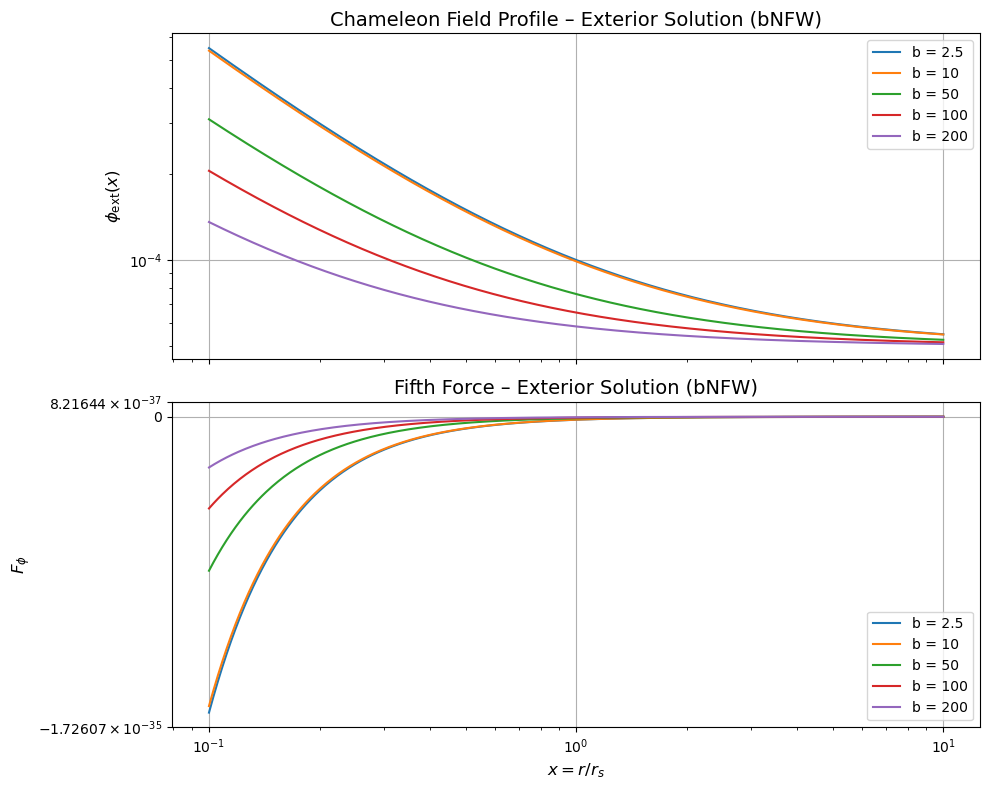

In [11]:
# Set up plots
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

for b in b_values:
    Cs = compute_Cs(b, phi_inf, B)

    # Chameleon field (phi_ext) for exterior region
    phi_ext = ((1 + x)**(2 - b) / (x * (b - 1) * (b - 2))) * B - Cs / x + phi_inf

    # Derivative of scalar field
    dphi_dx = ((1 + x)**(1 - b) * (x - b * x - 1) / (x**2 * (b - 1) * (b - 2))) * B + Cs / (r_s * x**2)

    # Fifth force: F_fifth = β / M_Pl * dφ/dr
    F_fifth = (beta / M_Pl) * dphi_dx

    # Plot phi_ext
    axes[0].plot(x, phi_ext, label=f'b = {b}')

    # Plot fifth force
    axes[1].plot(x, F_fifth, label=f'b = {b}')

# Formatting for φ_ext(x) plot
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_ylabel(r'$\phi_{\text{ext}}(x)$', fontsize=12)
axes[0].legend()
axes[0].grid(True)
axes[0].set_title('Chameleon Field Profile – Exterior Solution (bNFW)', fontsize=14)

# Formatting for fifth force plot
axes[1].set_xscale('log')
axes[1].set_yscale('symlog', linthresh=1e-20)
axes[1].set_xlabel(r'$x = r / r_s$', fontsize=12)
axes[1].set_ylabel(r'$F_{\phi}$', fontsize=12)
axes[1].legend()
axes[1].grid(True)
axes[1].set_title('Fifth Force – Exterior Solution (bNFW)', fontsize=14)

plt.tight_layout()
plt.show()

## Special Case: NFW Profile ($ b = 2 $)

When $ b = 2 $, the general expressions become undefined due to division by zero in the denominators. Therefore, we treat the **NFW profile** separately.

The exterior field gradient becomes:

$$
\frac{d\phi_{\text{ext}}}{dr} = \frac{B}{r_s x^2} \left[ \frac{1}{x + 1} + \ln(x + 1) \right] + \frac{C_s}{r_s x^2}
$$

After integrating this expression, the scalar field in the exterior region is given by:

$$
\phi_{\text{ext}}(x) = -\frac{1 + \ln(x + 1)}{x} B - \frac{C_s}{x} + \phi_\infty
$$

Where:
- $ x = r / r_s $
- $ B = \frac{\beta \rho_s r_s^2}{M_{\text{Pl}}} $: A derived parameter combining coupling strength and mass model
- $ C_s $: An integration constant determined from boundary conditions at the screening radius
- $ \phi_\infty $: Asymptotic value of the Chameleon field

### Matching Conditions at Screening Radius $ x_c $

To ensure continuity between the screened interior and unscreened exterior solutions, we match both the field and its derivative at the **screening radius** $ x_c = r_c / r_s $. This gives:

$$
x_c = \frac{B}{\phi_\infty} - 1
$$

$$
C_s = -\phi_\infty - B \ln\left( \frac{B}{\phi_\infty} \right)
$$

These matching conditions are crucial for computing the semi-analytical solution and determining the extent of screening.

## Unscreened Regime

In the **unscreened regime**, the scalar field does not reach a minimum within the halo, meaning no finite screening radius $ r_c $ exists. In this case:

- The **interior solution does not apply**
- The **exterior solution holds everywhere**
- The integration constant simplifies accordingly:

For general $ b > 2 $:
$$
C_s = -B
$$

For the **NFW case** ($ b = 2 $):
$$
C_s = -B r_s
$$

This leads to a fully **unscreened Chameleon field**, where the fifth force remains active throughout the entire halo.

In [13]:
# Function to compute C_s based on screening condition (for b = 2)
def compute_Cs_nfw(B, phi_inf):
    xc = B / phi_inf - 1
    Cs = -phi_inf - B * np.log(B / phi_inf)
    return Cs, xc

# Compute Chameleon field and fifth force
Cs_screened, xc_screened = compute_Cs_nfw(B, phi_inf)

# Screened regime (field vanishes below x_c)
Cs_screened, xc_screened = compute_Cs_nfw(B, phi_inf)
phi_ext_screened = -(1 + np.log(x + 1)) / x * B - Cs_screened / x + phi_inf
dphi_dr_screened = (B / (r_s * x**2)) * (1 / (x + 1) + np.log(x + 1)) + Cs_screened / (r_s * x**2)
F_fifth_screened = (beta / M_Pl) * dphi_dr_screened

# Unscreened regime (no screening radius, active fifth force everywhere)
Cs_unscreened = -B * r_s
phi_ext_unscreened = -(1 + np.log(x + 1)) / x * B - Cs_unscreened / x + phi_inf
dphi_dr_unscreened = (B / (r_s * x**2)) * (1 / (x + 1) + np.log(x + 1)) + Cs_unscreened / (r_s * x**2)
F_fifth_unscreened = (beta / M_Pl) * dphi_dr_unscreened


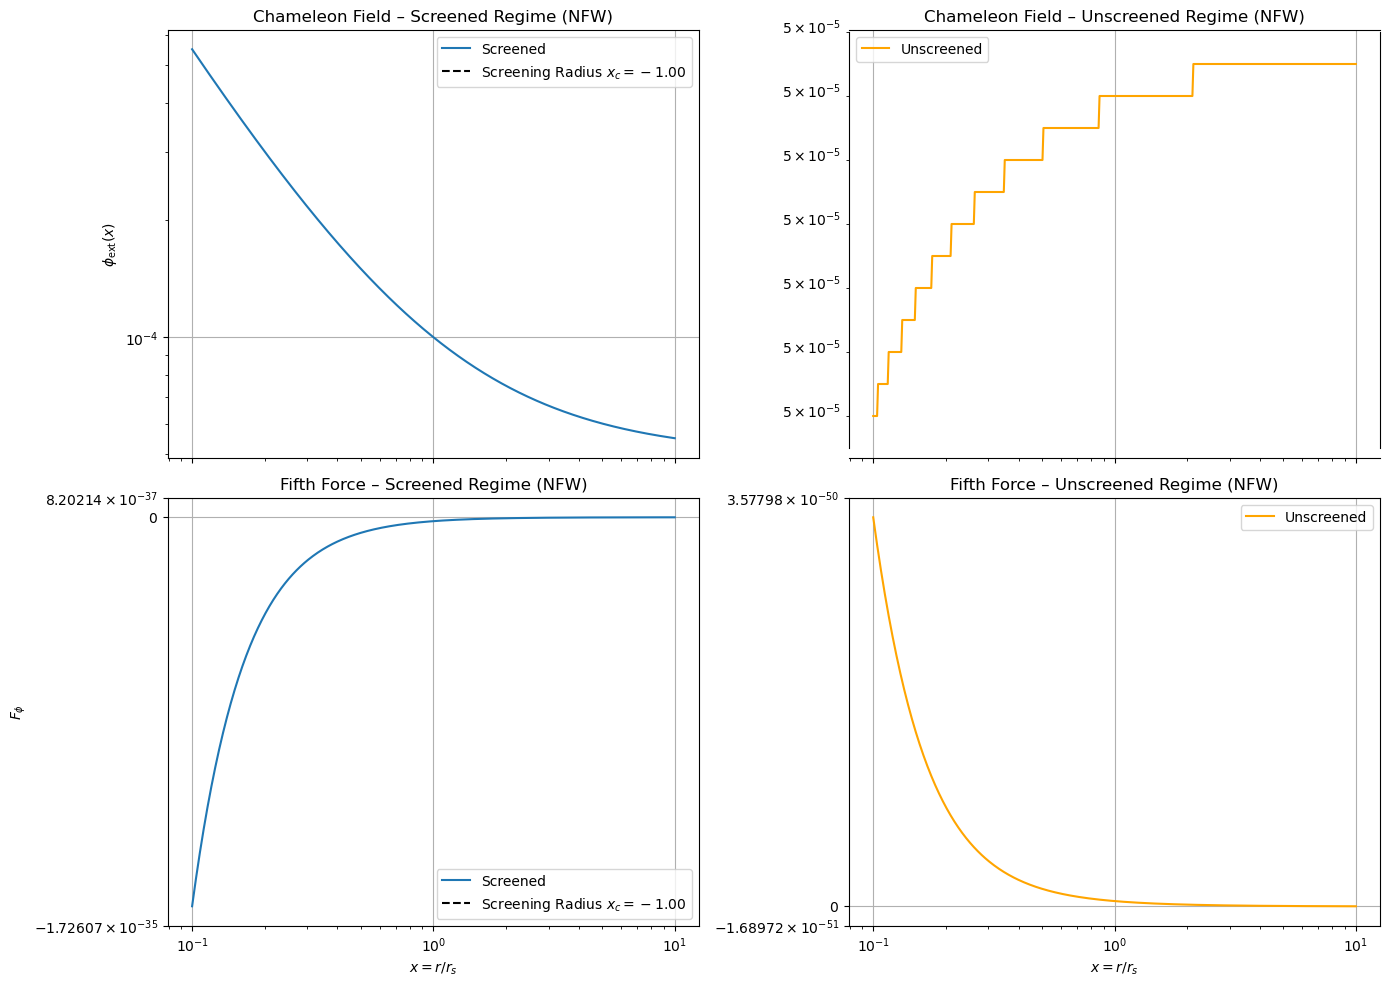

In [14]:
# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex='col')

# Screened Chameleon field
axes[0, 0].plot(x, phi_ext_screened, label='Screened')
axes[0, 0].axvline(xc_screened, color='k', linestyle='--', label=f'Screening Radius $x_c = {xc_screened:.2f}$')
axes[0, 0].set_xscale('log')
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylabel(r'$\phi_{\text{ext}}(x)$')
axes[0, 0].set_title('Chameleon Field – Screened Regime (NFW)', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True)

# Unscreened Chameleon field
axes[0, 1].plot(x, phi_ext_unscreened, label='Unscreened', color='orange')
axes[0, 1].set_xscale('log')
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('Chameleon Field – Unscreened Regime (NFW)', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True)

# Screened Fifth Force
axes[1, 0].plot(x, F_fifth_screened, label='Screened')
axes[1, 0].axvline(xc_screened, color='k', linestyle='--', label=f'Screening Radius $x_c = {xc_screened:.2f}$')
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('symlog')  # Handles negative values
axes[1, 0].set_xlabel(r'$x = r / r_s$')
axes[1, 0].set_ylabel(r'$F_{\phi}$')
axes[1, 0].set_title('Fifth Force – Screened Regime (NFW)', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True)

# Unscreened Fifth Force
axes[1, 1].plot(x, F_fifth_unscreened, label='Unscreened', color='orange')
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('symlog')
axes[1, 1].set_xlabel(r'$x = r / r_s$')
axes[1, 1].set_title('Fifth Force – Unscreened Regime (NFW)', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

## Generalized NFW (gNFW) Profile

The **generalized Navarro–Frenk–White (gNFW)** mass density profile extends the standard NFW model by allowing for a variable inner slope $ \gamma $, providing more flexibility in fitting galaxy cluster data:

$$
\rho(r) = \rho_s \left( \frac{r}{r_s} \right)^{-\gamma} \left( 1 + \frac{r}{r_s} \right)^{-(3 - \gamma)}
$$

Where:
- $ \rho_s $: Central density
- $ r_s $: Scale radius
- $ \gamma $: Inner logarithmic slope, constrained such that $ 0 < \gamma < 2 $

This profile allows for modeling both cored and cuspy dark matter halos depending on the value of $ \gamma $, making it particularly useful in testing modified gravity theories like Chameleon gravity.


### Exterior Chameleon Field Gradient

In the unscreened region ($ r > r_c $), the exterior solution for the scalar field gradient becomes:

$$
\frac{d\phi_{\text{ext}}}{dr} = \frac{B}{r_s x^2} \left[ \frac{x^{3-\gamma}}{3 - \gamma} \, {}_2F_1\left(3 - \gamma, 3 - \gamma, 4 - \gamma, -x\right) + 1 \right] + \frac{C_s}{r_s x^2}
$$

Where:
- $ x = \frac{r}{r_s} $
- $ B = \frac{\beta \rho_s r_s^2}{M_{\text{Pl}}} $
- $ {}_2F_1(a,b;c;z) $: Gaussian hypergeometric function
- $ C_s $: Integration constant determined from boundary conditions at the screening radius

This equation shows how the Chameleon field gradient depends on the mass profile through the hypergeometric function.


### Integrated Chameleon Field Profile

After integrating the above expression, the scalar field in the exterior region is given by:

$$
\phi_{\text{ext}}(x) = -B \left[ \frac{x^{3-\gamma}(1+x)^{\gamma-2} - 2 - x + \gamma}{\gamma - 2} + \frac{x^{3-\gamma}}{3 - \gamma} \, {}_2F_1(...) \right] - \frac{C_s}{x} + \phi_\infty
$$

This expression includes both the effects of the mass distribution and the coupling to the scalar field.


### Matching Conditions at Screening Radius $ r_c $

To determine the integration constant $ C_s $ and the screening radius $ r_c $, we impose continuity of the field and its derivative at the screening radius:

$$
x_c = \left[1 - \left(1 + \frac{\phi_\infty}{B} (\gamma - 2)\right)^{\frac{1}{2 - \gamma}} \right]^{-1} - 1
$$

$$
C_s = -B \left[\frac{x_c^{3-\gamma}}{3 - \gamma} \, {}_2F_1\left(3 - \gamma, 3 - \gamma, 4 - \gamma, -x_c\right) + 1\right]
$$

Where:
- $ x_c = r_c / r_s $: Dimensionless screening radius
- $ \phi_\infty $: Asymptotic value of the scalar field
- $ {}_2F_1 $: Hypergeometric function evaluated at $ -x_c $

These matching conditions are crucial for computing the semi-analytical Chameleon field solutions under the gNFW assumption.


In [16]:
# Choose a value for gamma
gamma = 1.2

# Function to compute C_s and screening radius xc 
def compute_screening_gnfw(gamma, B, phi_inf):
    """
    Compute the screening radius xc and constant Cs for a gNFW profile.
    Handles both screened and unscreened cases.
    """
    # Check for unscreened regime analytically
    B_min = phi_inf * (2 - gamma)
    if B <= B_min:
        print(f"Unscreened regime: B = {B:.2e} <= φ_inf * (2 - γ) = {B_min:.2e}")
        return np.inf, -B  # No finite screening radius

    try:
        base = 1 + (phi_inf / B) * (gamma - 2)
        exp_term = 1 / (2 - gamma)
        bracket_term = 1 - base**exp_term

        if bracket_term == 0:
            raise ValueError("Denominator would become zero — unscreened regime")

        xc = 1 / bracket_term - 1
        term = hyp2f1(3 - gamma, 3 - gamma, 4 - gamma, -xc)
        Cs = -B * (xc**(3 - gamma) / (3 - gamma) * term + 1)

        return xc, Cs

    except Exception as e:
        print(f"Unscreened regime: {e}")
        return np.inf, -B  # Fallback to unscreened
  

# Compute screening radius and Cs
xc_gnfw, Cs_gnfw = compute_screening_gnfw(gamma, B, phi_inf)

# Compute the Chameleon field gradient using Eq. 3.8
term = hyp2f1(3 - gamma, 3 - gamma, 4 - gamma, -x)
dphi_dr_gnfw = (B / (r_s * x**2)) * ((x**(3 - gamma) / (3 - gamma)) * term + 1) + Cs_gnfw / (r_s * x**2)

# Compute the integrated Chameleon field using Eq. 3.9
phi_ext_gnfw = -B * (
    (x**(3 - gamma) * (1 + x)**(gamma - 2) - 2 - x + gamma) / (gamma - 2) +
    (x**(3 - gamma) / (3 - gamma)) * term
) - Cs_gnfw / x + phi_inf

# Compute the fifth force
F_fifth_gnfw = (beta / M_Pl) * dphi_dr_gnfw


Unscreened regime: B = 2.05e-19 <= φ_inf * (2 - γ) = 4.00e-05


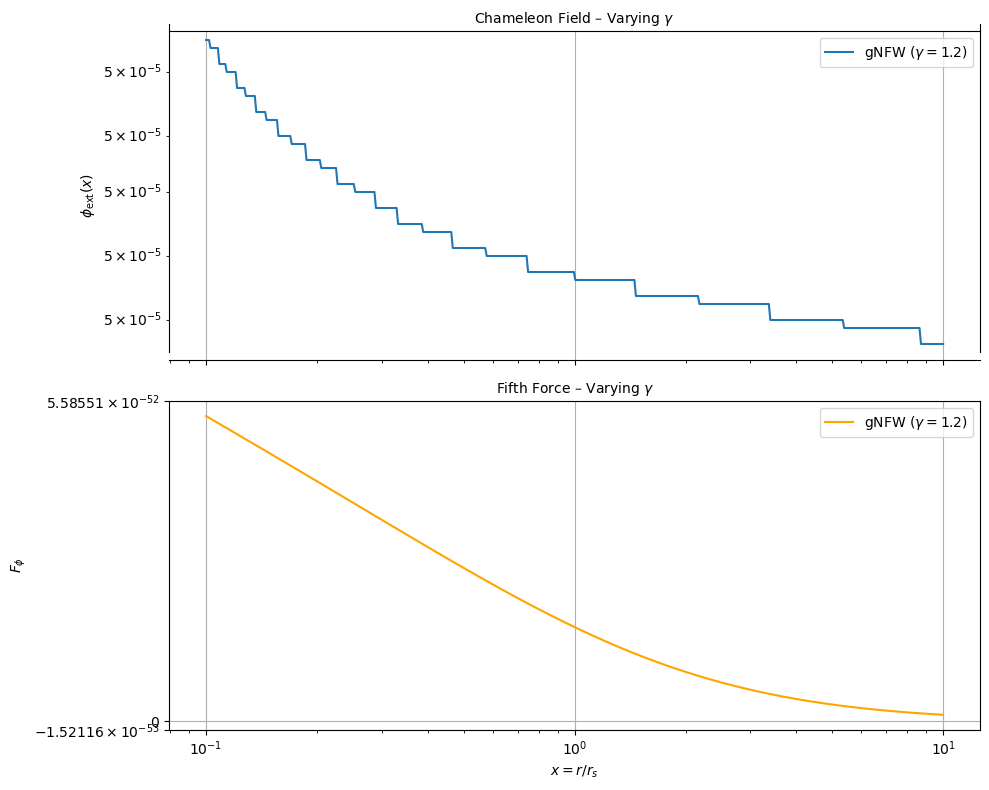

In [17]:
# Plotting
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot the Chameleon field
axes[0].plot(x, phi_ext_gnfw, label=fr'gNFW ($\gamma = {gamma}$)')
if xc_gnfw < 10:
    axes[0].axvline(xc_gnfw, color='k', linestyle='--', lw=1.5,
                    label=fr'Screening Radius $x_c = {xc_gnfw:.2f}$')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_ylabel(r'$\phi_{\text{ext}}(x)$')
axes[0].set_title(r'Chameleon Field – Varying $\gamma$', fontsize=10)
axes[0].legend()
axes[0].grid(True)

# Plot the Fifth Force
axes[1].plot(x, F_fifth_gnfw, label=fr'gNFW ($\gamma = {gamma}$)', color='orange')
if xc_gnfw < 10:
    axes[1].axvline(xc_gnfw, color='k', linestyle='--', lw=1.5,
                    label=fr'Screening Radius $x_c = {xc_gnfw:.2f}$')
axes[1].set_xscale('log')
axes[1].set_yscale('symlog')  # Handles negative values
axes[1].set_xlabel(r'$x = r / r_s$')
axes[1].set_ylabel(r'$F_{\phi}$')
axes[1].set_title(r'Fifth Force – Varying $\gamma$', fontsize=10)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

Rendering frame 1/50 for gamma = 0.50


C:\Users\Hazem\AppData\Local\Temp\ipykernel_8560\2716456347.py:65: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[0].clear()
C:\Users\Hazem\AppData\Local\Temp\ipykernel_8560\2716456347.py:98: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Rendering frame 2/50 for gamma = 0.55
Rendering frame 3/50 for gamma = 0.61
Rendering frame 4/50 for gamma = 0.66
Rendering frame 5/50 for gamma = 0.72
Rendering frame 6/50 for gamma = 0.77
Rendering frame 7/50 for gamma = 0.82
Rendering frame 8/50 for gamma = 0.88
Rendering frame 9/50 for gamma = 0.93
Rendering frame 10/50 for gamma = 0.99
Rendering frame 11/50 for gamma = 1.04
Rendering frame 12/50 for gamma = 1.10
Rendering frame 13/50 for gamma = 1.15
Rendering frame 14/50 for gamma = 1.20
Rendering frame 15/50 for gamma = 1.26
Rendering frame 16/50 for gamma = 1.31
Rendering frame 17/50 for gamma = 1.37
Rendering frame 18/50 for gamma = 1.42
Rendering frame 19/50 for gamma = 1.48
Rendering frame 20/50 for gamma = 1.53
Rendering frame 21/50 for gamma = 1.58
Rendering frame 22/50 for gamma = 1.64
Rendering frame 23/50 for gamma = 1.69
Rendering frame 24/50 for gamma = 1.75
Rendering frame 25/50 for gamma = 1.80
Rendering frame 26/50 for gamma = 1.81
Rendering frame 27/50 for gamma =

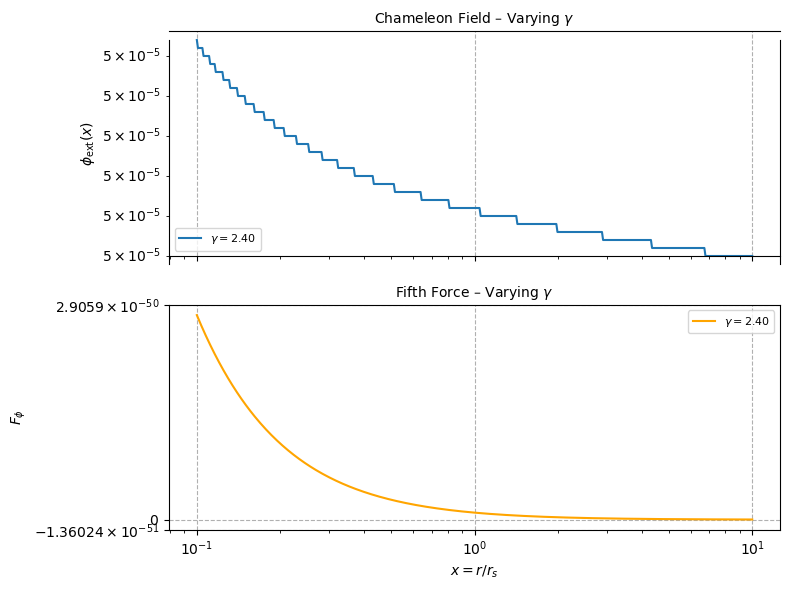

In [18]:
# gamma values
gamma_values = np.concatenate([
    np.linspace(0.5, 1.8, 25),
    np.linspace(1.81, 1.99, 15),
    np.linspace(2.01, 2.4, 10)
])

# Setup figure
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot formatting
for ax in axes:
    ax.clear()
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_ylabel(r'$\phi_{\text{ext}}(x)$')
axes[0].set_title('Chameleon Field – Varying $\\gamma$', fontsize=10)
axes[0].grid(True, which='both', linestyle='--')

axes[1].set_xscale('log')
axes[1].set_yscale('symlog')
axes[1].set_xlabel(r'$x = r / r_s$')
axes[1].set_ylabel(r'$F_{\text{fifth}}$')
axes[1].set_title('Fifth Force – Varying $\\gamma$', fontsize=10)
axes[1].grid(True, which='both', linestyle='--')

# Save GIF
writer = imageio.get_writer('chameleon_gnfw_animation.gif', mode='I', duration=0.2)

def compute_screening_gnfw(gamma, B, phi_inf):
    try:
        inner_term = (phi_inf / B) * (gamma - 2)
        base = 1 + inner_term
        if base <= 0:
            raise ValueError("Negative base — unscreened")
        exp_term = 1 / (2 - gamma)
        xc = (1 / (1 - base**exp_term)) - 1
        Fval = hyp2f1(3 - gamma, 3 - gamma, 4 - gamma, -xc)
        Cs = -B * (xc**(3 - gamma) / (3 - gamma) * Fval + 1)
        return xc, Cs
    except:
        return np.inf, -B  # Unscreened case

# Loop over gammas and save each frame
for i, gamma in enumerate(gamma_values):
    print(f"Rendering frame {i+1}/{len(gamma_values)} for gamma = {gamma:.2f}")

    # Recompute screening radius and integration constant
    xc, Cs = compute_screening_gnfw(gamma, B, phi_inf)

    # Compute Chameleon field gradient
    F = hyp2f1(3 - gamma, 3 - gamma, 4 - gamma, -x)
    dphi_dr = (B / (r_s * x**2)) * ((x**(3 - gamma) / (3 - gamma)) * F + 1) + Cs / (r_s * x**2)

    # Integrated Chameleon field
    phi_ext = -B * (
        (x**(3 - gamma) * (1 + x)**(gamma - 2) - 2 - x + gamma) / (gamma - 2) +
        (x**(3 - gamma) / (3 - gamma)) * F
    ) - Cs / x + phi_inf

    # Fifth force
    F_fifth = (beta / M_Pl) * dphi_dr

    # Replot everything
    axes[0].clear()
    axes[1].clear()

    # Re-formatting
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')
    axes[0].set_ylabel(r'$\phi_{\text{ext}}(x)$')
    axes[0].set_title('Chameleon Field – Varying $\\gamma$', fontsize=10)
    axes[0].grid(True)

    axes[1].set_xscale('log')
    axes[1].set_yscale('symlog')
    axes[1].set_xlabel(r'$x = r / r_s$')
    axes[1].set_ylabel(r'$F_{\phi}$')
    axes[1].set_title('Fifth Force – Varying $\\gamma$', fontsize=10)
    axes[1].grid(True)

    # Plot data
    axes[0].plot(x, phi_ext, label=fr'$\gamma = {gamma:.2f}$')
    axes[1].plot(x, F_fifth, label=fr'$\gamma = {gamma:.2f}$', color='orange')

    # Add vertical line if screenable
    if not np.isinf(xc):
        for ax in axes:
            ax.axvline(xc, color='k', linestyle='--', alpha=0.5)

    axes[0].legend(loc='lower left', fontsize=8)
    axes[1].legend(loc='upper right', fontsize=8)

    plt.tight_layout()

    # Draw canvas and convert to image
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    writer.append_data(image)

writer.close()
print(" Animation saved as 'chameleon_gnfw_animation.gif'")

## Burkert Solutions

The **Burkert mass density profile** is given by:

$$
\rho(r) = \rho_s \left(1 + \frac{r}{r_s}\right)\left[1 + \left(\frac{r}{r_s}\right)^2\right]
$$

For the Burkert model, the **exterior field gradient** is derived as:

$$
\frac{d\phi_{\text{ext}}}{dr} = \frac{C_s}{r_s x^2} + \frac{\mathcal{B}}{r_s x^2} \left[\frac{1}{4} \ln(x^2 + 1) + \frac{1}{2} \ln(x + 1) - \frac{1}{2} \tan^{-1}(x)\right],
$$

where:
- $ C_s $: Integration constant determined by matching conditions.
- $ \mathcal{B} = \frac{\beta \rho_s r_s^2}{M_{\text{Pl}}} $: Derived parameter combining coupling strength and mass model.

The **field profile** can be written as:

$$
\phi_{\text{ext}}(x) = -\frac{C}{x} + \frac{\mathcal{B}}{4x} \bigg[(x - 1) \ln(x^2 + 1)+ 2(x + 1)\left(\tan^{-1}(x) - \ln(x + 1)\right)\bigg] - \frac{\pi}{4} \mathcal{B} + \phi_\infty,
$$

### Matching Conditions

To match the exterior solution with the interior solution ($ \phi_{\text{int}} \approx 0 $), the integration constant $ C_s $ is determined as:

$$
C_s = \frac{1}{4} \mathcal{B} \left[-\log\left(x_c^2 + 1\right) - 2\log(x_c + 1) + 2\tan^{-1}(x_c)\right],
$$

where $ x_c = r_c / r_s $ is the dimensionless screening radius.

### Screening Equation

The **screening equation** is given by:

$$
\ln\left[\frac{x_c^2 + 1}{(x_c + 1)^2}\right] + 2\tan^{-1}(x_c) = \pi - 4\frac{\phi_\infty}{\mathcal{B}},
$$


In [20]:
# Define screening function for Burkert profile
def fs_screening(xc, phi_B_ratio):
    return (
        np.log((xc**2 + 1) / (xc + 1)**2)
        + 2 * np.arctan(xc)
        - np.pi
        + 4 * phi_B_ratio
    )

# Rescaled screening function
def rescaled_fs(xc, phi_B_ratio):
    return fs_screening(xc, phi_B_ratio) / fs_screening(0.01, phi_B_ratio)

# Compute Chameleon field gradient for Burkert profile
def dphi_dr_burkert(x, B, Cs):
    return Cs / (x**2) + (B / x**2) * (
        0.25 * np.log(x**2 + 1)
        + 0.5 * np.log(x + 1)
        - 0.5 * np.arctan(x)
    )

# Compute fifth force
def F_fifth(dphi_dr, beta, M_Pl):
    return -(beta / M_Pl) * dphi_dr


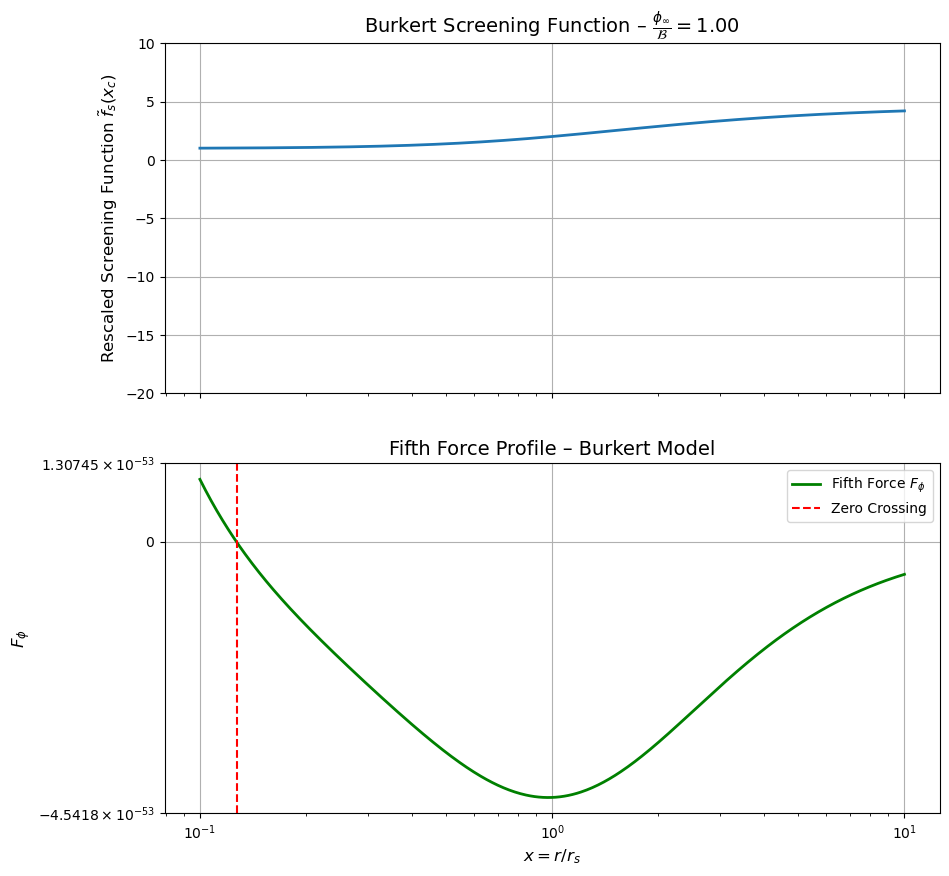

In [21]:
# Values of ϕ∞/B for animation
phi_B_ratios = np.arange(0.1, 1.01, 0.05)

# Setup figure and axes
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Fix bottom axis limits
axes[1].set_xscale('log')
axes[1].set_yscale('symlog')
axes[1].set_xlabel(r'$x = r / r_s$', fontsize=12)
axes[1].set_ylabel(r'$F_\phi$', fontsize=12)
axes[1].set_title('Fifth Force Profile – Burkert Model', fontsize=14)
axes[1].grid(True)

# Compute static fifth force for phi_inf/B = 0.6
phi_B_fixed = 0.6
Cs_fixed = 0.5 * B * (
    -np.log(1 + x[0]**2) - 2 * np.log(x[0] + 1) + 2 * np.arctan(x[0])
)
dphi_dr_fixed = dphi_dr_burkert(x, B, Cs_fixed)
F_phi_fixed = F_fifth(dphi_dr_fixed, beta, M_Pl)

# Plot static fifth force
axes[1].plot(x, F_phi_fixed, 'g-', lw=2, label=r'Fifth Force $F_\phi$')
axes[1].axvline(x[np.argmin(np.abs(dphi_dr_fixed))], color='r', linestyle='--', lw=1.5, label='Zero Crossing')
axes[1].legend()

# Top panel formatting
axes[0].set_xscale('log')
axes[0].set_ylabel(r'Rescaled Screening Function $\tilde{f}_s(x_c)$', fontsize=12)
axes[0].set_title('Burkert Screening Function vs $x_c$', fontsize=14)
axes[0].grid(True)

# Initialize line object for animation
line, = axes[0].plot([], [], lw=2)

# Animation update function
def update(frame):
    ratio = phi_B_ratios[frame]
    y = rescaled_fs(x, ratio)
    line.set_data(x, y)
    axes[0].set_ylim(-20, 10)  # Fixed y-axis
    axes[0].set_title(f'Burkert Screening Function – $\\frac{{\\phi_\\infty}}{{\\mathcal{{B}}}} = {ratio:.2f}$', fontsize=14)
    return line,

# Animation initialization
def init():
    line.set_data([], [])
    return line,

# Create animation
ani = FuncAnimation(
    fig,
    update,
    frames=len(phi_B_ratios),
    init_func=init,
    blit=True,
    interval=200,
    repeat=True
)

# Save as GIF
ani.save('burkert_screening_animation.gif', writer='pillow', fps=10)

plt.show()

In [22]:
# Vary φ∞/B from 0 to 1
phi_inf_over_B_values = np.linspace(0, 1, 20)

# Define screening function for Burkert profile
def fs_screening(x, phi_inf_over_B):
    return (
        np.log((x**2 + 1) / (x + 1)**2)
        + 2 * np.arctan(x)
        - np.pi
        + 4 * phi_inf_over_B
    )

# Rescale fs(x) by fs(0)
fs_0 = fs_screening(0.01, phi_inf_over_B_values)  # shape (20,)
fs_x = np.zeros((len(phi_inf_over_B_values), len(x)))  # shape (20, 500)

for i, phi_B in enumerate(phi_inf_over_B_values):
    fs_x[i, :] = fs_screening(x, phi_B)

fs_rescaled = fs_x / fs_0[:, None]  # shape (20, 500)

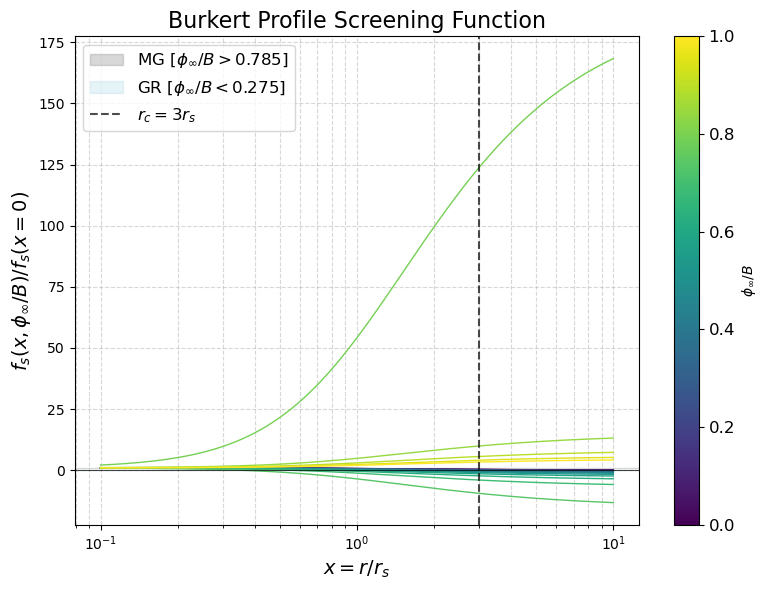

In [23]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot rescaled screening function for each φ∞/B
for i, phi_B in enumerate(phi_inf_over_B_values):
    ax.plot(x, fs_rescaled[i], color=plt.cm.viridis(phi_B), lw=1)

# Add colorbar
norm = Normalize(vmin=0, vmax=1)
sm = ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # Dummy array for colorbar
cbar = plt.colorbar(sm, ax=ax, label=r'$\phi_\infty / B$')  # Specify ax here
cbar.ax.tick_params(labelsize=12)

# Shaded regions for MG and GR regimes
ax.axhspan(0.785, 1.0, color='gray', alpha=0.3, label=r'MG [$\phi_\infty / B > 0.785$]')
ax.axhspan(0.0, 0.275, color='lightblue', alpha=0.3, label=r'GR [$\phi_\infty / B < 0.275$]')

# Vertical dashed line at rc = 3rs
ax.axvline(3, color='k', linestyle='--', label=r'$r_c = 3r_s$', alpha=0.7)

# Horizontal line at fs(x) = 0
ax.axhline(0, color='k', linestyle='-', lw=0.8, alpha=0.7)

# Labels and title
ax.set_xlabel(r'$x = r / r_s$', fontsize=14)
ax.set_ylabel(r'$f_s(x, \phi_\infty / B) / f_s(x=0)$', fontsize=14)
ax.set_title('Burkert Profile Screening Function', fontsize=16)

# Log scale for x-axis
ax.set_xscale('log')

# Legend
ax.legend(fontsize=12, loc='upper left')

# Grid
ax.grid(True, which='both', linestyle='--', alpha=0.5)

# Tight layout
plt.tight_layout()

# Save or show plot
plt.savefig('burkert_screening_function.png', dpi=300)
plt.show()

## Isothermal Solutions

The **Isothermal mass density model** is characterized by a flat core at small radii, making it distinct from cuspy profiles like NFW. For this model, the Chameleon field behavior is described as follows:

### **Field Gradient**

The exterior field gradient for the Isothermal profile is given by:

$$
\frac{d\phi_{\text{ext}}}{dr} = \left[ C_s - \mathcal{B} \left( \frac{x}{\sqrt{x^2 + 1}} - \ln\left(\sqrt{x^2 + 1} - x\right) \right) \right] \frac{1}{r_s x^2},
$$

where:
- $ C_s $: Integration constant determined by matching conditions.
- $ \mathcal{B} = \frac{\beta \rho_s r_s^2}{M_{\text{Pl}}} $: Derived parameter combining coupling strength and mass model.

### **Field Profile**

After integrating Eq. (3.14), the field profile becomes:

$$
\phi_{\text{ext}}(x) = -\frac{\ln(\sqrt{x^2 + 1} + x)}{x} \mathcal{B} - \frac{C_s}{x} + \phi_\infty,
$$

where:
$$
C_s = \phi_\infty x_c - \mathcal{B} \ln(\sqrt{x_c^2 + 1} + x_c).
$$

### **Screening Equation**

Repeating the process explained in Section 3, the screening equation is derived as:

$$
\sqrt{x_c^2 + 1} = \frac{\mathcal{B}}{\phi_\infty},
$$

which has a solution only when:

$$
\left(\frac{\mathcal{B}}{\phi_\infty}\right)^2 > 1.
$$

The resulting **screening radius** is:

$$
r_c = r_s \sqrt{\left(\frac{\mathcal{B}}{\phi_\infty}\right)^2 - 1}.
$$

### **Unscreened Regime**

In the unscreened regime ($ x_c = 0 $), the integration constant vanishes ($ C_s = 0 $). In the bottom panel of Fig. 2, we show the screening function profiles for the Isothermal mass density profile corresponding to Eq. (3.17):

$$
f_s(x_c) = \sqrt{x_c^2 + 1} - \frac{\mathcal{B}}{\phi_\infty}.
$$

### **Comparison with Burkert Profile**

In contrast to the Burkert profile, the Isothermal model ensures that there always exists a solution to the screening function even in the limit $ \frac{\phi_\infty}{\mathcal{B}} \to 1 $. This property makes the Isothermal profile particularly robust in capturing the screening mechanism across a wide range of parameters.


In [25]:
# Define screening function for Isothermal profile
def fs_screening(x, phi_B_ratio):
    return (
        np.log((x**2 + 1) / (x + 1)**2)
        + 2 * np.arctan(x)
        - np.pi
        + 4 * phi_B_ratio
    )

# Rescale fs(x) by fs(0)
fs_0 = fs_screening(0.01, phi_inf / B)
fs_x = fs_screening(x, phi_inf / B)
fs_rescaled = fs_x / fs_0

# Compute Chameleon field gradient for Isothermal profile
def dphi_dr_isothermal(x, B, Cs):
    return (Cs - B * (x / np.sqrt(x**2 + 1) - np.log(np.sqrt(x**2 + 1) - x))) / (r_s * x**2)

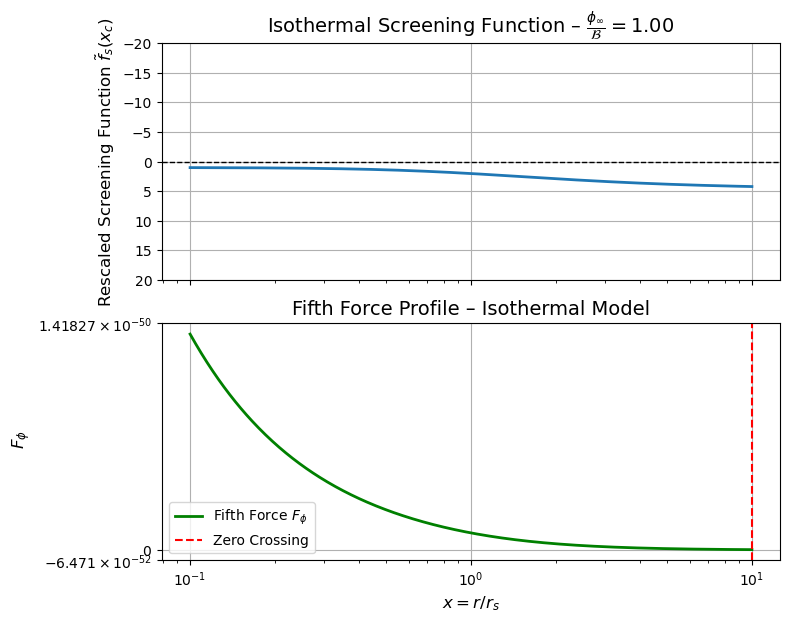

In [26]:
# Values of ϕ∞/B to test
phi_B_ratios = np.linspace(0.1, 1.0, 20)

# Setup figure and axes
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Initialize line object for animation
line, = axes[0].plot([], [], lw=2)

# Animation update function
def update(frame):
    ratio = phi_B_ratios[frame]
    y = rescaled_fs(x, ratio)
    line.set_data(x, y)
    axes[0].set_ylim(20, -20)  # Fixed y-axis limits
    axes[0].set_title(f'Isothermal Screening Function – $\\frac{{\\phi_\\infty}}{{\\mathcal{{B}}}} = {ratio:.2f}$', fontsize=14)
    return line,

# Animation initialization
def init():
    line.set_data([], [])
    return line,

# Create animation
ani = FuncAnimation(
    fig,
    update,
    frames=len(phi_B_ratios),
    init_func=init,
    blit=True,
    interval=200,
    repeat=True
)

# Top panel formatting
axes[0].set_xscale('log')
axes[0].set_ylabel(r'Rescaled Screening Function $\tilde{f}_s(x_c)$', fontsize=12)
axes[0].axhline(0, color='black', linestyle='--', linewidth=1)
axes[0].grid(True)

# Bottom panel: Fifth force
Cs = 0.5 * B * (-np.log(1 + x[0]**2) - 2 * np.log(x[0] + 1) + 2 * np.arctan(x[0]))
dphi_dr = dphi_dr_isothermal(x, B, Cs)
F_phi = F_fifth(dphi_dr, beta, M_Pl)

axes[1].plot(x, F_phi, 'g-', lw=2, label=r'Fifth Force $F_\phi$')
axes[1].axvline(x[np.argmin(np.abs(dphi_dr))], color='r', linestyle='--', lw=1.5, label='Zero Crossing')

# Formatting bottom panel
axes[1].set_xscale('log')
axes[1].set_yscale('symlog')
axes[1].set_xlabel(r'$x = r / r_s$', fontsize=12)
axes[1].set_ylabel(r' $F_\phi$', fontsize=12)
axes[1].set_title('Fifth Force Profile – Isothermal Model', fontsize=14)
axes[1].legend()
axes[1].grid(True)

# Tight layout
plt.tight_layout()

# Save as GIF
ani.save('isothermal_screening_animation.gif', writer='pillow', fps=10)

# Show plot
plt.show()

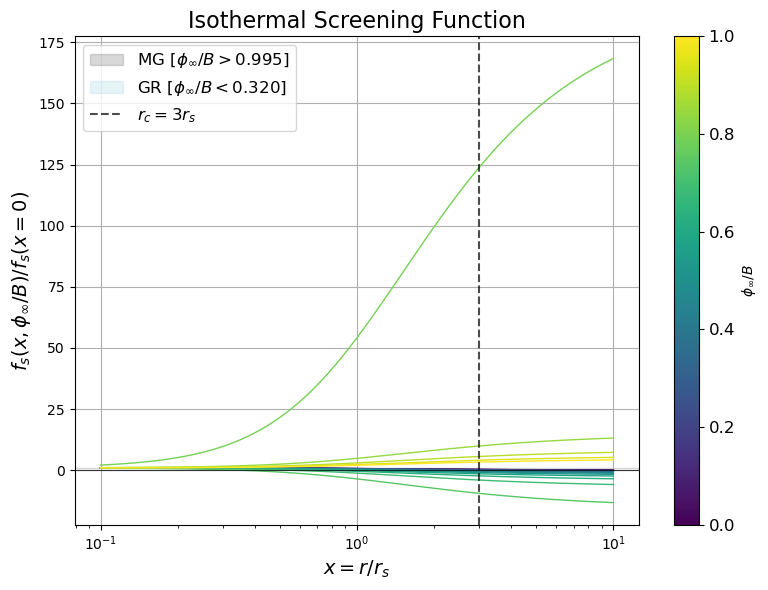

In [27]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot rescaled screening function for each φ∞/B
for ratio in phi_inf_over_B_values:
    y = rescaled_fs(x, ratio)
    ax.plot(x, y, color=plt.cm.viridis(ratio), lw=1)

# Mark zero line
ax.axhline(0, color='black', linestyle='-', lw=0.8, alpha=0.7)

# Shaded regions for MG and GR regimes
mg_region = ax.axhspan(0.785, 1.0, color='gray', alpha=0.3, label=r'MG [$\phi_\infty / B > 0.995$]')
gr_region = ax.axhspan(0.0, 0.275, color='lightblue', alpha=0.3, label=r'GR [$\phi_\infty / B < 0.320$]')

# Vertical dashed line at rc = 3rs
rc_line = ax.axvline(3, color='k', linestyle='--', alpha=0.7, label=r'$r_c = 3r_s$')

# Add colorbar
norm = Normalize(vmin=0, vmax=1)
sm = ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # Dummy array for colorbar
cbar = plt.colorbar(sm, ax=ax, label=r'$\phi_\infty / B$')  # Specify ax here
cbar.ax.tick_params(labelsize=12)

# Formatting top panel
ax.set_xscale('log')
ax.set_ylabel(r'Rescaled Screening Function $\tilde{f}_s(x_c)$', fontsize=12)
ax.set_title('Isothermal Screening Function vs $x_c$', fontsize=14)
ax.grid(True)

# Labels and title
ax.set_xlabel(r'$x = r / r_s$', fontsize=14)
ax.set_ylabel(r'$f_s(x, \phi_\infty / B) / f_s(x=0)$', fontsize=14)
ax.set_title('Isothermal Screening Function', fontsize=16)

# Log scale for x-axis
ax.set_xscale('log')

# Grid
ax.grid(True)

# Tight layout
plt.tight_layout()

# Show legend
ax.legend(fontsize=12, loc='upper left')

# Save or show plot
plt.savefig('isothermal_screening_function.png', dpi=300)
plt.show()

## Einasto Solutions

The **Einasto mass density model** is characterized by its smooth, shallow profile at small radii, making it a popular choice for modeling galaxy clusters. For this model, the Chameleon field behavior is described as follows:

### **Field Gradient**

The gradient of the Chameleon field for the Einasto profile is given by:

$$
\frac{d\phi_{\text{ext}}}{dr} = \frac{C_s}{r_s x^2} - \mathcal{B} \frac{8^{-m} e^{2m} m^{1-3m}}{r_s x^2} \Gamma(3m, 2m x^{1/m}),
$$

where:
- $ C_s $: Integration constant determined by matching conditions.
- $ \mathcal{B} = \frac{\beta \rho_s r_s^2}{M_{\text{Pl}}} $
- $ \Gamma(n, z) $: Upper incomplete gamma function defined as:
  $$
  \Gamma(n, z) = \int_z^\infty dt \, t^{n-1} e^{-t}.
  $$

### **Field Profile**

The exterior field profile is expressed as:

$$
\phi_{\text{ext}}(x) = \phi_\infty - \frac{C_s}{x} + \frac{\mathcal{B}}{x} 8^{-m} e^{2m} m^{1-3m} \times
$$
$$
\left[ 2^m m^m x \Gamma\left(2m, 2m x^{1/m}\right) - \Gamma\left(3m, 2m x^{1/m}\right) \right].
$$

### **Junction Conditions**

Despite the complexity of the field profile, analytical solutions exist for the junction conditions between the screened and unscreened regimes:

$$
r_c = r_s \left[ \frac{1}{2m} Q^{-1}\left(2m, \frac{4^m \phi_\infty m^{2m-1}}{\mathcal{B} \, e^{2m} \Gamma(2m)} \right) \right]^m,
$$
$$
C_s = 8^{-m} e^{2m} m^{1-3m} \Gamma(3m, 2m x_s^{1/m}) \mathcal{B},
$$

where:
- $ Q^{-1}(y, a) $: Inverse of the upper regularized incomplete gamma function.
- $ x_s = r_s / r_s = 1 $ (dimensionless scale radius).

### **Unscreened Case**

For cases where there is no screening, the integration constant simplifies to:

$$
C_s = 8^{-m} e^{2m} m^{1-3m} \Gamma(3m) \mathcal{B}.
$$


In [29]:
# Define parameters for Einasto profile
m = 0.2  # Shape parameter for Einasto profile

def dphi_dr_einasto(x, B, Cs, rs, m):
    # Upper incomplete gamma function Γ(3m, 2m * x^(1/m))
    lower_limit = 2 * m * x**(1/m)
    gamma_3m = gammaincc(3*m, lower_limit)

    # Coefficient from the paper
    prefactor = 8**(-m) * np.exp(2*m) * m**(1 - 3*m)

    # Compute field gradient
    dphi_dr = (Cs / (rs * x**2)) - (B / (rs * x**2)) * prefactor * gamma_3m
    return dphi_dr
    
# Define screening function for Einasto profile
def fs_screening(x, phi_B_ratio):
    return (
        np.log((x**2 + 1) / (x + 1)**2)
        + 2 * np.arctan(x)
        - np.pi
        + 4 * phi_B_ratio
    )


# Rescale fs(x) by fs(0)
fs_0 = fs_screening(0.01, phi_inf / B)
fs_x = fs_screening(x, phi_inf / B)
fs_rescaled = fs_x / fs_0

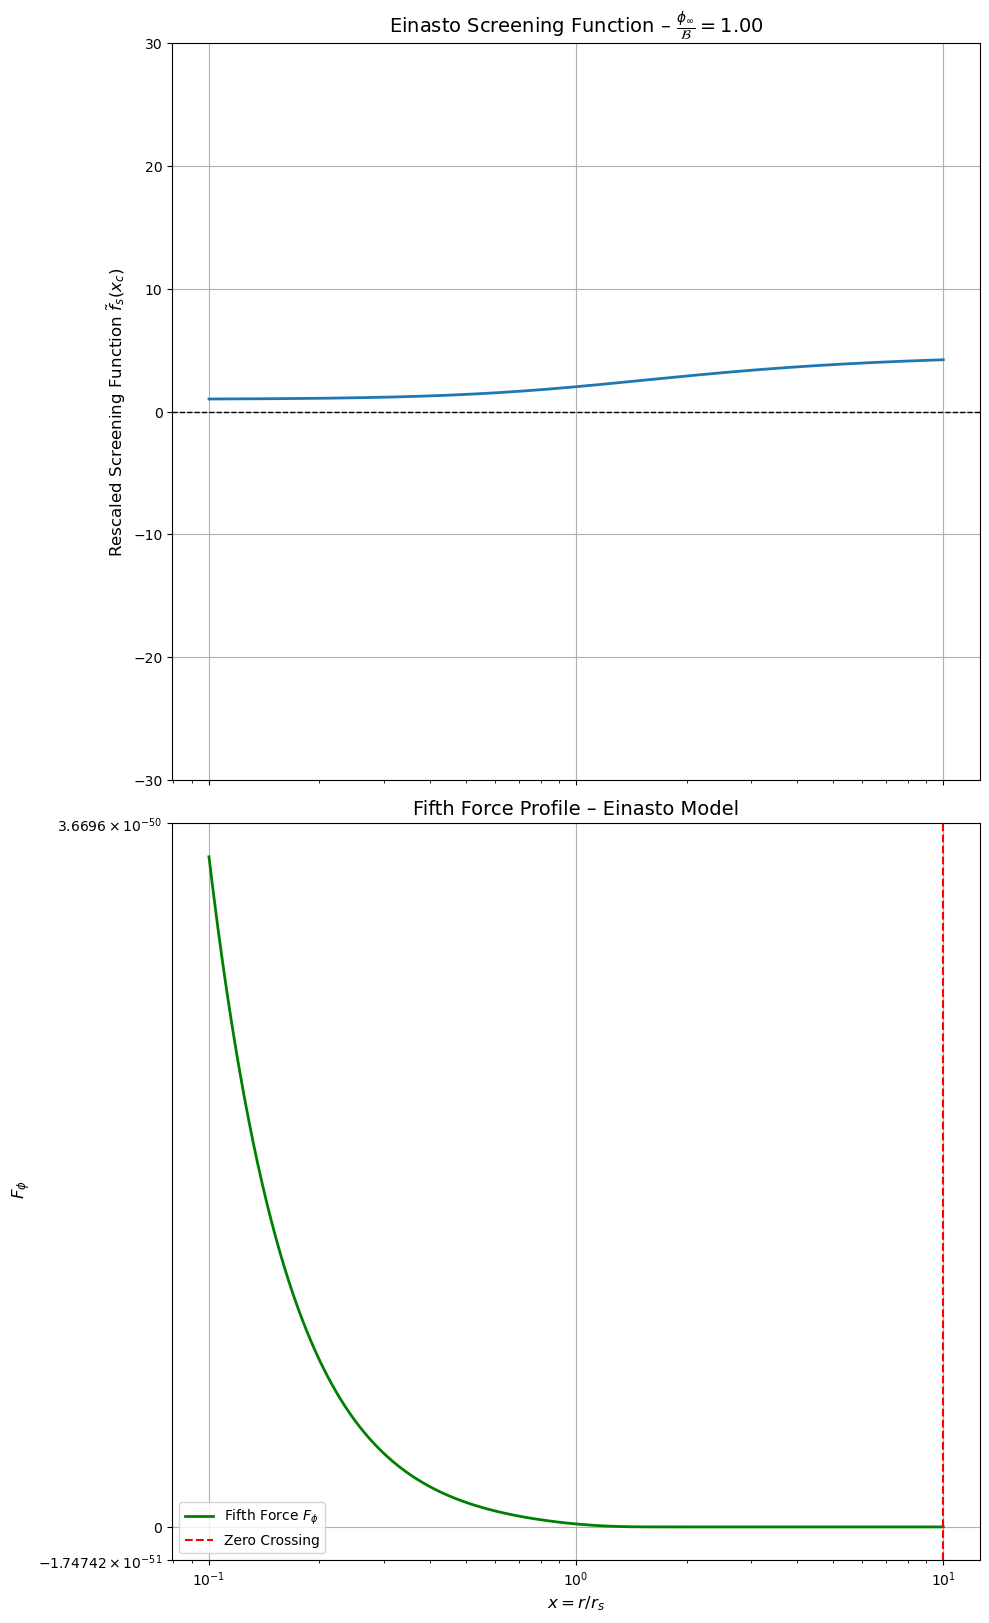

In [30]:
# Setup figure and axes
fig, axes = plt.subplots(2, 1, figsize=(10, 16), sharex=True)

# Initialize line object for animation
line, = axes[0].plot([], [], lw=2)

# Animation update function
def update(frame):
    ratio = phi_B_ratios[frame]
    y = rescaled_fs(x, ratio)
    line.set_data(x, y)
    axes[0].set_ylim(-30, 30)  # Fixed y-axis limits
    axes[0].set_title(f'Einasto Screening Function – $\\frac{{\\phi_\\infty}}{{\\mathcal{{B}}}} = {ratio:.2f}$', fontsize=14)
    return line,

# Animation initialization
def init():
    line.set_data([], [])
    return line,

# Create animation
ani = FuncAnimation(
    fig,
    update,
    frames=len(phi_B_ratios),
    init_func=init,
    blit=True,
    interval=200,
    repeat=True
)

# Top panel formatting
axes[0].set_xscale('log')
axes[0].set_ylabel(r'Rescaled Screening Function $\tilde{f}_s(x_c)$', fontsize=12)
axes[0].axhline(0, color='black', linestyle='--', linewidth=1)
axes[0].grid(True)

# Bottom panel: Fifth force
Cs = 0.5 * B * (-np.log(1 + x[0]**2) - 2 * np.log(x[0] + 1) + 2 * np.arctan(x[0]))
dphi_dr = dphi_dr_einasto(x, B, Cs, r_s, m)
F_phi = F_fifth(dphi_dr, beta, M_Pl)

axes[1].plot(x, F_phi, 'g-', lw=2, label=r'Fifth Force $F_\phi$')
axes[1].axvline(x[np.argmin(np.abs(dphi_dr))], color='r', linestyle='--', lw=1.5, label='Zero Crossing')

# Formatting bottom panel
axes[1].set_xscale('log')
axes[1].set_yscale('symlog')
axes[1].set_xlabel(r'$x = r / r_s$', fontsize=12)
axes[1].set_ylabel(r' $F_\phi$', fontsize=12)
axes[1].set_title('Fifth Force Profile – Einasto Model', fontsize=14)
axes[1].legend()
axes[1].grid(True)

# Tight layout
plt.tight_layout()

# Save as GIF
ani.save('einasto_screening_animation.gif', writer='pillow', fps=10)

# Show plot
plt.show()

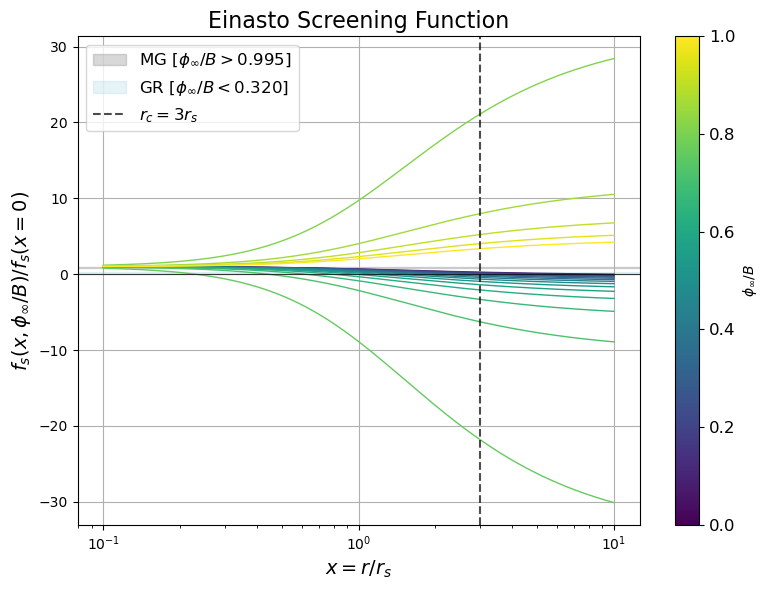

In [31]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot rescaled screening function for each φ∞/B
for ratio in phi_B_ratios:
    y = rescaled_fs(x, ratio)
    ax.plot(x, y, color=plt.cm.viridis(ratio), lw=1)

# Mark zero line
ax.axhline(0, color='black', linestyle='-', lw=0.8, alpha=0.7)

# Shaded regions for MG and GR regimes
mg_region = ax.axhspan(0.785, 1.0, color='gray', alpha=0.3, label=r'MG [$\phi_\infty / B > 0.995$]')
gr_region = ax.axhspan(0.0, 0.275, color='lightblue', alpha=0.3, label=r'GR [$\phi_\infty / B < 0.320$]')

# Vertical dashed line at rc = 3rs
rc_line = ax.axvline(3, color='k', linestyle='--', alpha=0.7, label=r'$r_c = 3r_s$')

# Add colorbar
norm = Normalize(vmin=0, vmax=1)
sm = ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # Dummy array for colorbar
cbar = plt.colorbar(sm, ax=ax, label=r'$\phi_\infty / B$')  # Specify ax here
cbar.ax.tick_params(labelsize=12)

# Formatting top panel
ax.set_xscale('log')
ax.set_ylabel(r'Rescaled Screening Function $\tilde{f}_s(x_c)$', fontsize=12)
ax.set_title('Einasto Screening Function vs $x_c$', fontsize=14)
ax.grid(True)

# Labels and title
ax.set_xlabel(r'$x = r / r_s$', fontsize=14)
ax.set_ylabel(r'$f_s(x, \phi_\infty / B) / f_s(x=0)$', fontsize=14)
ax.set_title('Einasto Screening Function', fontsize=16)

# Log scale for x-axis
ax.set_xscale('log')

# Grid
ax.grid(True)

# Tight layout
plt.tight_layout()

# Show legend
ax.legend(fontsize=12, loc='upper left')

# Save or show plot
plt.savefig('Einasto_screening_function.png', dpi=300)
plt.show()

---
## Refrences:
[1] L. Pizzuti et al., “Mass modeling and kinematics of galaxy clusters in modified gravity,” Journal of Cosmology and Astroparticle Physics, vol. 2024, no. 11, pp. 014–014, Nov. 2024, doi: https://doi.org/10.1088/1475-7516/2024/11/014.